Today is a brief introduction to PyTorch. PyTorch is a library mainly for Deep learning. 

At its core it does two main things:
1. manipulates the so-called tensor data structure on GPU, just like NumPy can manipulate ndarray on CPU.
2. provides a automatic differentiation engine and some convenient helper functions for deep learning

# 0. Introduction and Importing

First we import the most fundamental packages/modules of PyTorch. Whenever we work with PyTorch, we mostly likely need to import these.

In [2]:
import torch # * a Tensor library like NumPy, with strong GPU support
import torch.optim as optim # functions related to optimization algorithms

import torch.nn as nn # a neural networks library deeply integrated with autograd designed for maximum flexibility
import torch.nn.functional as F
# nn and nn.functional works kinda similarly. If you are interested in their subtile difference, please check out this discussion https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597

import torch.utils.data as data # utility functions such as DataLoader

Tensor as a mathematical concept is a bit hard to explain here, but for now we can think of it as a generalization of matrix. A grayscale image is a matrix, but a colored image with 3 channels can be thought of a tensor.

Check if we are using GPU. Computation will be very slow if not.

In [3]:
torch.cuda.is_available()

True

In most cases, it would say False. If so, at the top left corner, select "Runtime-Change runtime type-Hardware accelerator-GPU" and redo the import again.

Next we import some vision-related packges

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Finally some generic helper packages

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import cv2

In [6]:
SEED = 1234


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1. Using Pretrained Network

We can download existing models online

In [7]:
import torchvision.models as models
from PIL import Image

# * we use Resnet pre-trained weights to help initialize weights and make our classification task perform better
resnet18_model = models.resnet18(weights=True)
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()


def prepare_an_img_resnet(img):
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
  
  img = Image.open(img)
  img = preprocess(img)
  img = torch.unsqueeze(img, 0)
  return img

c:\Users\gaura\.conda\envs\robot_vision_class\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Since we are not training the model, the gradients for this operation are not needed and can be temporarily disabled using torch.no_grad().
with torch.no_grad():
    # ! get the tensor form of the image
    output = resnet18_model(prepare_an_img_resnet('cat.jpg').to(device))

probabilities = torch.nn.functional.softmax(output[0], dim=0)
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Egyptian cat 0.30802950263023376
Siamese cat 0.16848227381706238
Angora 0.12675005197525024
tabby 0.07222902774810791
hamper 0.04242419824004173


'wget' is not recognized as an internal or external command,
operable program or batch file.


There is a lot more can be done here to make the pretrained model predict more labels that it's not included in the ImageNet dataset. The process is called finetuning. We will not introduce it here, but if you are interested, please take a look at this [article](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

Now let's work on our own model, we will train a slight variation of a network called *AlexNet*. This is a landmark model in deep learning, and arguably kickstarted the current (and ongoing, and massive) wave of innovation in modern AI in 2012. AlexNet was the first real-world demonstration of a *deep* classifier that was trained end-to-end on data and that outperformed all other ML models thus far.

We will train AlexNet using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

# 2. Data Loading and Pre-processing

CIFAR 10 is included in PyTorch because it's so widely used.

In [9]:
ROOT = '.data' # folder with our data
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

Files already downloaded and verified


### Data augmentation

Next, we will do data augmentation. DL models are data hungry. A good trick to increse the size of dataset without the hardwork of acquiring/labeling more data is data augmentation. 

For each training image we will randomly rotate it (by up to 5 degrees), flip/mirror with probability 0.5, shift by +/-1 pixel. 

In [10]:
# here we compose all the data augmentation actions we want to do.
# note that there is no need to do data augmentation on the testing set.
train_transforms = [transforms.RandomRotation(5),
                  transforms.RandomHorizontalFlip(0.5),
                  transforms.RandomCrop(32, padding = 2),
                  transforms.ToTensor()]

### Normalization and Standardization

To put it simple:

***normalize***: making your data range in [0, 1]

**standardize**: making your data's mean=0 and std=1

In modern deep learning, sometimes it's often okay if you don't do these, but they will often help with faster training and better accuracy. For a more detailed explanation on the benefits, please see this [article](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn).

Calculate the mean and standard deviation of pixel values so we can standardize the dataset later. 

In [11]:
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [12]:
# append the standardization to the list of transformations we want to do.
train_transforms.append(transforms.Normalize(mean = means, std = stds))
train_transforms = transforms.Compose(train_transforms)

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [13]:
train_transforms

Compose(
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=2)
    ToTensor()
    Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
)

Apply these transformations on our training set and testing set separately

In [14]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Leave out 10% of data from the training set as the validation set. The model won't train on the validation set, but only do inference on it. 

Validation set is similar to test set (hence the similar transformations), but it's a good practice to only run your model on test set for only **once**, and use your validation set as a gauge of how well your model generalize while tweaking hyper-parameters

In [15]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

The final step is to create a DataLoader object. 

DataLoader object can be thought of as an iterator we use in Python. Deep learning dataset are usually too large to fit on memory (RAM, usually 8GB to 32GB) entirely, so we want to have a DataLoader that can spit out a fixed size of the dataset every time we need more data to process.

Batch_size can be thought of the number of data point we will ask the DataLoader to spit out. After DataLoader spit out a chunk partitioned from the entire dataset, we will send it to GPU's memory (VRAM) so GPU can work on it. Similarly, GPU has limited memory, usually ranging from a few GB to 40GB, so the number should be adjusted according to the VRAM of your GPU.

In [16]:
BATCH_SIZE = 64

# we only shuffle the training set 
train_iterator = torch.utils.data.DataLoader(train_data,
                                             batch_size=BATCH_SIZE, 
                                             shuffle=True)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE, 
                                            shuffle=False)

# 3. Defining the Model

Next up is defining the model.

AlexNet will have the following architecture:

* There are 5 2D convolutional layers (which serve as *feature extractors*), followed by 3 linear layers (which serve as the *classifier*).
* All layers (except the last one) have `ReLU` activations. (Use `inplace=True` while defining your ReLUs.)
* All convolutional filter sizes have kernel size 3 x 3 and padding 1. 
* Convolutional layer 1 has stride 2. All others have the default stride (1).
* Convolutional layers 1,2, and 5 are followed by a 2D maxpool of size 2.
* Linear layers 1 and 2 are preceded by Dropouts with Bernoulli parameter 0.5.

* For the convolutional layers, the number of channels is set as follows. We start with 3 channels and then proceed like this:

  - $3 \rightarrow 64 \rightarrow 192 \rightarrow384 \rightarrow256 \rightarrow 256$

  In the end, if everything is correct you should get a feature map of size $2\times2 \times 256 = 1024$.

* For the linear layers, the feature sizes are as follows:

  - $1024 \rightarrow 4096 \rightarrow 4096 \rightarrow 10$.

  (The 10, of course, is because 10 is the number of classes in CIFAR-10).

The PyTorch syntax for a 2d convolution layer is `torch.nn.Conv2d(in_channels, out_channels, kernel_size, ...)`. You may notice that we do not have a parameter that directly controls the dimension of the output image produced by the convolution operation. The formula to compute such number can be found at the very bottom of [this doc](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

In [17]:
class AlexNet_1(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            # define according to the steps described above
            # 1 conv
            nn.Conv2d(in_channels=3, 
                      out_channels=64, 
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            # 2 conv
            nn.Conv2d(in_channels=64, 
                      out_channels=192, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            # 3 conv
            nn.Conv2d(in_channels=192, 
                      out_channels=384, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(inplace=True),
            # 4 conv
            nn.Conv2d(in_channels=384, 
                      out_channels=256, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(inplace=True),
            # 5 conv
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            # define according to the steps described above
            # 1 linear
            nn.Dropout(p=0.5),
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            # 2 linear
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [18]:
OUTPUT_DIM = 10
model1 = AlexNet_1(OUTPUT_DIM)

Another equivalent way of defining the network looks like this:

In [19]:
# class AlexNet_2(nn.Module):
#     def __init__(self, output_dim):
#       super().__init__()
#         # 1 conv
#       self.conv1 = nn.Conv2d(in_channels=3, 
#                       out_channels=64, 
#                       kernel_size=3, 
#                       stride=2, 
#                       padding=1)
        
#       self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#       self.conv2 = nn.Conv2d(in_channels=64, 
#                       out_channels=192, 
#                       kernel_size=3, 
#                       stride=1, 
#                       padding=1)
#       self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # 3 conv
#       self.conv3 = nn.Conv2d(in_channels=192, 
#                       out_channels=384, 
#                       kernel_size=3, 
#                       stride=1, 
#                       padding=1)

#         # 4 conv
#       self.conv4 = nn.Conv2d(in_channels=384, 
#                       out_channels=256, 
#                       kernel_size=3, 
#                       stride=1, 
#                       padding=1)
        
#       self.conv5 = nn.Conv2d(in_channels=256, 
#                       out_channels=256, 
#                       kernel_size=3, 
#                       stride=1, 
#                       padding=1)
#       self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        
#       self.classifier = nn.Sequential(
#             # define according to the steps described above
#             # 1 linear
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, 4096),
#             nn.ReLU(inplace=True),
#             # 2 linear
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, output_dim),
#         )

#     def forward(self, x):
#       # first conv layer
#       x = self.conv1(x)
#       x = self.maxpool1(x)
#       x = F.relu(x)
      
#       # second conv layer
#       x = self.conv2(x)
#       x = self.maxpool2(x)
#       x = F.relu(x)

#       # third conv layer
#       x = self.conv3(x)
#       x = F.relu(x)

#       # fourth conv layer
#       x = self.conv4(x)
#       x = F.relu(x)

#       # fifth conv layer
#       x = self.conv5(x)
#       x = self.maxpool3(x)
#       x = F.relu(x)

#       h = x.view(x.shape[0], -1)
#       x = self.classifier(h)
#       return x, h

In [20]:
# OUTPUT_DIM = 10
# model2 = AlexNet_2(OUTPUT_DIM)

You may notice that we almost exclusively use 3*3 kernel(filter). I personally don't know if there is any theoretical benefit, but here is a article summerizing the [heuristics](https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15) around it. An excellent class note from Stanford's CS231n also does a great job discussing this at the end of the [article](https://cs231n.github.io/convolutional-networks/#architectures).

We also have many channels, even though a typical image only has 3 channels. This is because by the formula above, the number of kernel we can have is related to number of the output channel. We want more kernels so they can learn different important things: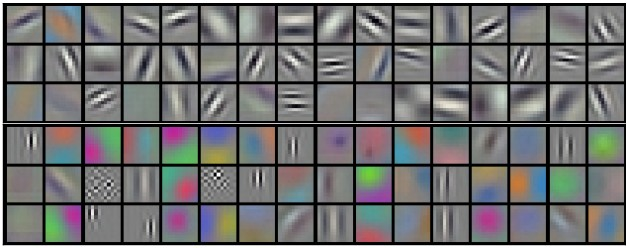

Note that how some of the kernels performs like edge detectors, but for different kind of edges.

# 4. Training the Model

Before we start the training, we will need to initialize our models. To put it simple, we are assigning the intial values of weight. We could just assign them all 0 to start with, and it would work. But data scientists have come up with smarter ways to to this to make things work even better. 

For convolutional layers we will initialize using the *Kaiming Normal* scheme, also known as *He Normal*. For the linear layers we initialize using the *Xavier Normal* scheme, also known as *Glorot Normal*. For both types of layer we initialize the bias terms to zeros.

In [21]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [22]:
model1.apply(initialize_parameters)

AlexNet_1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

Next we create a optimizer and loss function.

Here the optimzer is called Adam. It's a slightly more advanced version of the common optimization algorithm called gradient descent. There are a few other optimizers out there, but for most common tasks we will just use Adam.

The loss function is the cross entropy loss. You may notice that in our model definition, there is no activation function for the very last layer. This is because the loss function itself has softmax baked in to do multi-class classification. Part of the design choice is explained [here](https://stackoverflow.com/questions/57516027/does-pytorch-apply-softmax-automatically-in-nn-linear)

In [23]:
optimizer = optim.Adam(model1.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model1.to(device)
criterion = criterion.to(device)

We will then need a bunch of boilerplate functions

In [24]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [25]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

What we did above:
- put our model into train mode with `model.train()`. Some layers should act differently during traning than testing.

For each iteration

- acquire [batch_size] pairs of (image, label) from the data loader 
- send the data we just acquired to GPU.
- clear the gradients calculated from the last iteration. 
- pass our batch of images, x, through to model to get predictions, y_pred
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter backward (hence backpropagation)
- update the parameters by taking an optimizer step forward
- update our metrics

In [26]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop with a few differences:
1. we put our model into evaluation mode with `model.eval()` for the same reason above.
2. we wrap the iterations inside a `with torch.no_grad()` because for testing time we no longer need to calculate gradient, and we can save memory and computational time for not doing it.
3. We also do not need to update our optimizer because we are no longer optimizing our model.


In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally we can start training. 

For each epoch, we run through the training process once to update our model. It's important to notice that the entire dataset is being run through once for just 1 training process. Then we use the updated model to run through the evaluation process to get our validation accuracy to gauge how well our model generalizes.

We repeat this for 25 epochs here.

In [29]:
EPOCHS = 25
# used to record history of the traning
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
# Fill training code here
for epoch in range(EPOCHS):
    start_time = time.time() # record start time

    train_loss, train_acc = train(model=model, 
                                  iterator=train_iterator, 
                                  optimizer=optimizer, 
                                  criterion=criterion, 
                                  device=device)
    torch.save(model, './model1_'+str(epoch)+'.pt')
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    val_loss, val_acc = evaluate(model=model, 
                                 iterator=valid_iterator, 
                                 criterion=criterion, 
                                 device=device)
    val_loss_history.append(val_loss) 
    val_acc_history.append(val_acc)
    end_time = time.time()
    minute, second = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1}/{EPOCHS}') 
    print(f'Training Loss: {train_loss}.. Validation Loss: {val_loss}')
    print(f'Training Accuracy: {train_acc}.. Validtion Accuracy: {val_acc}')
    print(f'Time Elapsed: {minute} in minute.. {second} in second')
    print('')

Epoch: 1/25
Training Loss: 1.0689743361012503.. Validation Loss: 1.0386163298087785
Training Accuracy: 0.6291725852272727.. Validtion Accuracy: 0.6396360759493671
Time Elapsed: 0 in minute.. 18 in second

Epoch: 2/25
Training Loss: 1.0290891449390487.. Validation Loss: 0.953117639958104
Training Accuracy: 0.6433327414772727.. Validtion Accuracy: 0.6687104430379747
Time Elapsed: 0 in minute.. 18 in second

Epoch: 3/25
Training Loss: 0.979949755424803.. Validation Loss: 0.9046188525006741
Training Accuracy: 0.6634188565340909.. Validtion Accuracy: 0.6930379746835443
Time Elapsed: 0 in minute.. 18 in second

Epoch: 4/25
Training Loss: 0.9491872224448756.. Validation Loss: 0.8998049535328829
Training Accuracy: 0.6757368607954546.. Validtion Accuracy: 0.694620253164557
Time Elapsed: 0 in minute.. 18 in second

Epoch: 5/25
Training Loss: 0.9218864760954272.. Validation Loss: 0.8799872111670578
Training Accuracy: 0.6855246803977273.. Validtion Accuracy: 0.7001582278481012
Time Elapsed: 0 in m

In [ ]:
# optimizer = optim.Adam(model2.parameters(), lr = 1e-3)
# device = torch.device('cuda')
# criterion = nn.CrossEntropyLoss()

# model = model2.to(device)
# criterion = criterion.to(device)

# EPOCHS = 25
# # used to record history of the traning
# train_loss_history = []
# train_acc_history = []
# val_loss_history = []
# val_acc_history = []
# # Fill training code here
# for epoch in range(EPOCHS):
#     start_time = time.time() # record start time

#     train_loss, train_acc = train(model=model, 
#                                   iterator=train_iterator, 
#                                   optimizer=optimizer, 
#                                   criterion=criterion, 
#                                   device=device)
#     torch.save(model, './model2_'+str(epoch)+'.pt')
#     train_loss_history.append(train_loss)
#     train_acc_history.append(train_acc)
    
#     val_loss, val_acc = evaluate(model=model, 
#                                  iterator=valid_iterator, 
#                                  criterion=criterion, 
#                                  device=device)
#     val_loss_history.append(val_loss) 
#     val_acc_history.append(val_acc)
#     end_time = time.time()
#     minute, second = epoch_time(start_time, end_time)
    
#     print(f'Epoch: {epoch+1}/{EPOCHS}') 
#     print(f'Training Loss: {train_loss}.. Validation Loss: {val_loss}')
#     print(f'Training Accuracy: {train_acc}.. Validtion Accuracy: {val_acc}')
#     print(f'Time Elapsed: {minute} in minute.. {second} in second')
#     print('')

As we can see, the 2 models have almost identical performances.

# 5. Evaluating the Model

We don't have time to train these models in the class, so I will just load the one I trained at home

In [51]:
test_model = AlexNet_1(10)
test_model = torch.load('model1_24.pt', map_location=torch.device('cpu'))
test_model = test_model.to(device)

In [52]:
_, test_acc = evaluate(model=test_model, 
                        iterator=test_iterator, 
                        criterion=criterion, 
                        device=device)
print('Our test accuracy is:', test_acc)

Our test accuracy is: 0.7573646496815286


Let's try it on some other images in the wild then!

In [53]:
def prepare_an_img(img):
  img = cv2.imread(img, 1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)
  img = cv2.resize(img, (32, 32))
  img = test_transforms(img).float()
  img = torch.unsqueeze(img, 0)
  return img

Let's test it on a dog, a plane, a cat, and a dog that looks like a cat

In [58]:
dog = prepare_an_img('alt_dog.png')
dog = dog.to(device)
y_pred = F.softmax(test_model(dog)[0], dim=1)
torch.argmax(y_pred)

tensor(9, device='cuda:0')

Label 5 is dog (0-indexed), so it got this one right.

In [62]:
plane = prepare_an_img('plane.jpg')
plane = plane.to(device)
y_pred = F.softmax(test_model(plane)[0], dim=1)
torch.argmax(y_pred)

tensor(0, device='cuda:0')

Label 0 is airplane, so it got this one right.

In [63]:
cat = prepare_an_img('cat.jpg')
cat = cat.to(device)
y_pred = F.softmax(test_model(cat)[0], dim=1)
torch.argmax(y_pred)

tensor(0, device='cuda:0')

Label 0 is airplane, so it got this one wrong.

In [64]:
cat_dog = prepare_an_img('cat-dog.jpg')
cat_dog = cat_dog.to(device)
y_pred = F.softmax(test_model(cat_dog)[0], dim=1)
torch.argmax(y_pred)

tensor(7, device='cuda:0')

Label 7 is horse, so it got the cat-dog wrong.

You may notice that our model perform not as well as we would like. There are multiple reasons:
1. AlexNet itself is, by today's standard, not a very powerful network architecture
2. We only trained for 25 epochs, which isn't very many
3. The CIFAR-10 dataset is a toy dataset. It doesn't contain many data points, and every image it includes is also very small (32*32)

One way to tackle this is to invoke a much stronger network.

# 6. Adversarial Attack (Optional)

It's also possible to add a little bit of noise to completely fool the neural network. If you are interested in this, search the keyword adversarial attack.

In [ ]:
with torch.no_grad():
    output = resnet18_model(prepare_an_img_resnet('img1.png').to(device))

probabilities = torch.nn.functional.softmax(output[0], dim=0)
# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())